In [35]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Tetris Bot

In [1]:
import gym_tetris
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
cuda:0


In [2]:
env = gym_tetris.make('Tetris-v0')
BATCH_SIZE = 32
GAMMA = 0.99
MULISTEP_GAMMA = 0.99

EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 5000000
TARGET_UPDATE = 50
NUM_STATES = env.action_space.n
MULTISTEP_PARAM = 5
MOVEMENT_COST = 0.01
LAYER_HISTORY = 4
TRAIN_RATE = 4
LEARNING_RATE = 10**-4
SCREEN_HEIGHT = 84
SCREEN_WIDTH = 84
NUM_MEMORIES = 1000000

steps_done = 0

def curr_eps(steps):
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps / EPS_DECAY)

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        fleeting_memory = Transition(*args)
        self.memory[self.position] = fleeting_memory
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, good_fraction=20, bad_fraction=20):
        return random.sample(self.memory, batch_size)
        

    def __len__(self):
        return len(self.memory)

In [4]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride  + 1

class DQN(nn.Module):
    def __init__(self, h, w, depth=LAYER_HISTORY):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4), 4, 2), 3, 1)
        self.convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4), 4, 2), 3, 1)
        self.linear_size = self.convh * self.convw * 64

        self.fc1 = nn.Linear(self.linear_size, 512)
        self.output_layer = nn.Linear(512, 12)

    # Called with either one element to determine next action, or a batch
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        return self.output_layer(x)

In [5]:
def clean_state(state_var):
    """Returns a greyscale image with pixels taking values in [0,1]. Also adds a batch dimension"""
    state_var = T.ToPILImage()(state_var)
    state_var = T.Grayscale()(state_var)
    state_var = T.Resize((84, 84))(state_var)
    state_var = T.ToTensor()(state_var)
    return state_var

def get_screen(screen=None, human=False):
    if screen is None and not human:
        screen = env.render(mode='rgb_array')
    if human:
        bla = env.render()
        screen = env.env.screen
        
    # Turn greyscale
    screen = clean_state(screen)
    return screen

def shift_state(old_screens, new_screen):
    latest_frames = torch.cat([torch.cat([old_screens[:, 1:], new_screen.unsqueeze(0)], dim=1)])
    return latest_frames.type(torch.FloatTensor)

def shift_screens(old_screens, new_screen):
    return old_screens[1:] + [new_screen]

def get_state(*screens):
    latest_frames = torch.cat([s.unsqueeze(0) for s in screens], dim=1)
    return latest_frames.type(torch.FloatTensor)

def init_state(screen):
    latest_frames = torch.cat([screen for _ in range(LAYER_HISTORY)]).unsqueeze(0)
    return latest_frames.type(torch.FloatTensor)

In [6]:
# Get screen size so that we can initialize layers correctly based on shape
init_screen = get_screen()
screen_height, screen_width = SCREEN_HEIGHT, SCREEN_WIDTH

In [7]:
load_net_prefix = './models/tetrisBotConv1v'
load_net_number = 6
net_to_load = f'{load_net_prefix}{load_net_number}'
try:
    policy_net = torch.load(net_to_load)
    policy_net.eval()
    target_net = torch.load(net_to_load)
    target_net.eval()
    print(f'{net_to_load} loaded...')
except:
    policy_net = DQN(screen_height, screen_width).to(device)
    target_net = DQN(screen_height, screen_width).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    print(f'Fell back to creating a new net...')

./models/tetrisBotConv1v6 loaded...


In [8]:
optimizer = optim.Adam(policy_net.parameters(), lr=10**-4)
memory = ReplayMemory(NUM_MEMORIES)

def select_action(state, deterministic=False):
    global steps_done
    sample = random.random()
    eps_threshold = curr_eps(steps_done)
    steps_done += 1
    if sample > eps_threshold and not deterministic:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(NUM_STATES)]], device=device, dtype=torch.long)


episode_durations = []
lines_cleared = []
eps_values = []

def plot_durations(save=None):
    fig = plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.plot(np.array(lines_cleared) * 200)
    plt.plot(np.array(eps_values) * 500)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    if save is not None:
        fig.savefig(save, bbox_inches='tight')
        
    if is_ipython:
        display.clear_output(wait=True)
#         display.display(plt.gcf())
        plt.show()

In [9]:
def compute_loss_single(state, action, next_state, reward):
    return _compute_loss(state, action, next_state, reward, batch_size=1)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    next_state_batch = torch.cat(batch.next_state).to(device)
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    # Compute Huber loss
    loss = _compute_loss(state_batch, action_batch, next_state_batch, reward_batch)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def _compute_loss(_state, _action, _next_state, _reward, batch_size=BATCH_SIZE):
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(_state).gather(1, _action)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
#     next_state_values = target_net(_next_state).max(1)[0].detach()
    
#     Double Q learning:
    next_state_values = target_net(_next_state)[0][policy_net(_next_state).argmax(1)[0]].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + _reward

    # Compute Huber loss
    return F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

In [10]:
def did_piece_fall(env):
    return (env.unwrapped.game.falling_piece is None)

def create_reward(this_env, block_placed, action, is_done, info,
                  old_height, old_lines, include_score=True, include_height=True):
    """Assumes states are 21 x 10"""
    if not block_placed:
        # Punish a little for doing something that isn't the empty move, or down
        if action == 0:
            return 0
        else:
            return -MOVEMENT_COST
    if is_done:
        return -1
    
    total_reward = 0
    if include_height:
        if info['height'] > old_height: 
            # Punish a little more the closer you are to the top
            total_reward += (1 + info['height'] / 10) * (old_height - info['height']) / 12
    
    line_diff = this_env.unwrapped.game.complete_lines - old_lines
    
    if include_score and line_diff != 0:
        total_reward += 2 ** (line_diff) - 1
    
    return total_reward

def train(num_episodes = 1000, human=False): 
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        height, lines = 0, 0
        env.reset()
        last_state = get_screen(human=human)
        last_full_state = init_state(last_state)
        state = get_screen(human=human)
        full_state = init_state(state)
        if not human:
            state_array = [last_full_state] * MULTISTEP_PARAM
            reward_array = [0] * MULTISTEP_PARAM
            
            reward_sum = 0
            array_pos = 0
            next_array_pos = 1
            warmup = 1
        for t in count():

            # Select and perform an action
            action = select_action(full_state.to(device), deterministic=human)
            # Can only perform an action once every three frames anyway...
            state, _, done, info = env.step(action.item())
            action = action.to('cpu')
            piece_fell = did_piece_fall(env)
            if not done:
                state, _, done, info = env.step(0)
                piece_fell = (piece_fell or did_piece_fall(env))
            if not done:
                state, _, done, info = env.step(0)
                piece_fell = (piece_fell or did_piece_fall(env))

            # Observe new state
            state = get_screen(state, human)
            full_state = shift_state(full_state, state)
            
            if not human:
                state_array[array_pos] = full_state

                    
                reward_single = create_reward(env, piece_fell, action, done, info, height, lines)
                reward_sum = (MULISTEP_GAMMA * reward_sum) + reward_single - (MULISTEP_GAMMA ** MULTISTEP_PARAM) * reward_array[array_pos]
                reward_array[array_pos] = reward_single
                reward_sum = torch.tensor([reward_sum]).type(torch.float)
                
                # Store the transition in memory
                if warmup > MULTISTEP_PARAM:
#                     with torch.no_grad():
#                         loss = compute_loss_single(state_array[next_array_pos], action, state, reward_sum) ** ((1 - curr_eps(steps_done)) / 2 + 0.05)
#                     memory.push(state_array[next_array_pos], action, state, reward_sum, bias=np.array([loss.cpu()])[0])
                    memory.push(state_array[next_array_pos], action, full_state, reward_sum)
                
                # Perform one step of the optimization (on the target network)
                optimize_model()
                if done:
                    episode_durations.append(t + 1)
                    lines_cleared.append(lines)
                    eps_values.append(curr_eps(steps_done))
                    plot_durations('latestConv.png')
                    break

            else:
                if done:
                    break

            # Set up params for next cycle
            height = info['height']
            lines = env.unwrapped.game.complete_lines
            last_state = state
            last_full_state = full_state
            if not human:
                array_pos = (array_pos + 1) % MULTISTEP_PARAM
                next_array_pos = (next_array_pos + 1) % MULTISTEP_PARAM
                warmup += 1
            
        if not human:
            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())
        torch.cuda.empty_cache()

def watch_model(rounds=1000):
    with torch.no_grad():
        train(rounds, human=True)

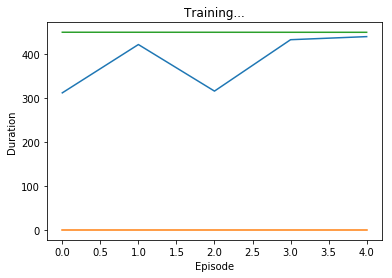

In [11]:
# Testing
train(5)

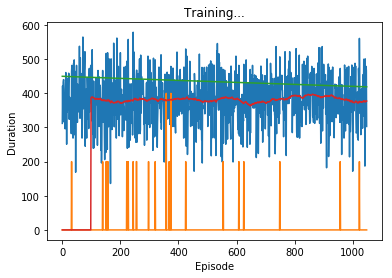

In [ ]:
idx = 7
while True:
    train(2000)
    torch.save(policy_net, f'{load_net_prefix}{idx}')
    idx += 1

In [14]:
import gc
for obj in gc.get_objects():
    if torch.is_tensor(obj) and obj.is_cuda:
        print(type(obj), obj.size())

<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 4, 8, 8])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 32, 4, 4])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.Tensor'

In [35]:
import gc
gc.collect()

14081

In [1]:
len(memory)

NameError: name 'memory' is not defined

In [44]:
watch_model()

KeyboardInterrupt: 

In [15]:
curr_eps(steps_done)

0.0765313099202285